In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import lmdb
import pickle
import imageio

In [5]:
path = '/home/zhong/data/gopro_ds/train/'
seqs = os.listdir(path)
seqs_info = {}
length = 0
for i in range(len(seqs)):
    seq_info = {}
    seq_info['seq'] = seqs[i]
    length_temp = len(os.listdir(path+seqs[i]+'/blur_gamma'))
    seq_info['length'] = length_temp
    length += length_temp
    seqs_info[i] = seq_info
seqs_info['length'] = length
seqs_info['num'] = len(seqs)
f = open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_info_train.pkl', 'wb')
pickle.dump(seqs_info, f)
f.close()

In [6]:
print(seqs_info['num'], seqs_info['length'], seqs_info[0]['seq'], seqs_info[0]['length'])

22 2103 GOPR0379_11_00 100


In [8]:
# code for creating lmdb
path = '/home/zhong/data/gopro_ds/train/'
# dataset_type = 'train'
dataset_type = 'train_gt'
env = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_'+dataset_type, map_size=1099511627776)
txn = env.begin(write=True)
for i in range(seqs_info['num']):
#     subpath = path + seqs_info[i]['seq'] + '/blur_gamma/'
    subpath = path + seqs_info[i]['seq'] + '/sharp/'
    imgs = os.listdir(subpath)
    nums = [int(img.split('.')[0]) for img in imgs]
    nums.sort()
    gap = nums[0]-0
#     print(seqs_info[i]['length'])
    for img in imgs:
        img_path = subpath + img
        seq_idx = i
        frame_idx = int(img.split('.')[0])-gap
        key = '%03d_%08d' % (seq_idx, frame_idx)
        data = cv2.imread(img_path)
#         _data = imageio.imread(img_path)
        txn.put(key=key.encode(), value=data)
#         txn.put(key=('_'+key).encode(), value=_data)
txn.commit()
env.close()

In [9]:
path = '/home/zhong/data/gopro_ds/valid/'
seqs = os.listdir(path)
seqs_info = {}
length = 0
for i in range(len(seqs)):
    seq_info = {}
    seq_info['seq'] = seqs[i]
    length_temp = len(os.listdir(path+seqs[i]+'/blur_gamma'))
    seq_info['length'] = length_temp
    length += length_temp
    seqs_info[i] = seq_info
seqs_info['length'] = length
seqs_info['num'] = len(seqs)
f = open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_info_valid.pkl', 'wb')
pickle.dump(seqs_info, f)
f.close()

In [10]:
print(seqs_info['num'], seqs_info['length'], seqs_info[0]['seq'], seqs_info[0]['length'])

11 1111 GOPR0854_11_00 100


In [12]:
# code for creating lmdb
path = '/home/zhong/data/gopro_ds/valid/'
# dataset_type = 'valid'
dataset_type = 'valid_gt'
env = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_'+dataset_type, map_size=1099511627776)
txn = env.begin(write=True)
for i in range(seqs_info['num']):
#     subpath = path + seqs_info[i]['seq'] + '/blur_gamma/'
    subpath = path + seqs_info[i]['seq'] + '/sharp/'
    imgs = os.listdir(subpath)
    nums = [int(img.split('.')[0]) for img in imgs]
    nums.sort()
    gap = nums[0]-0
#     print(seqs_info[i]['length'])
    for img in imgs:
        img_path = subpath + img
        seq_idx = i
        frame_idx = int(img.split('.')[0])-gap
        key = '%03d_%08d' % (seq_idx, frame_idx)
        data = cv2.imread(img_path)
#         _data = imageio.imread(img_path)
        txn.put(key=key.encode(), value=data)
#         txn.put(key=('_'+key).encode(), value=_data)
txn.commit()
env.close()

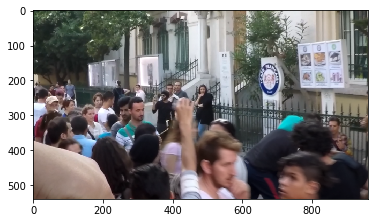

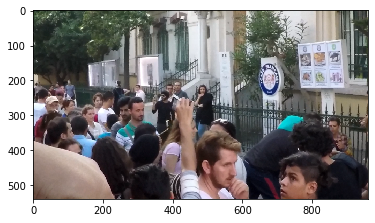

(540, 960, 3) (540, 960, 3)


In [13]:
env = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_train', map_size=1099511627776)
env_gt = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_train_gt', map_size=1099511627776)
txn = env.begin()
txn_gt = env_gt.begin()
test = txn.get('021_00000039'.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(540,960,3)
test_gt = txn_gt.get('021_00000039'.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(540,960,3)
plt.imshow(test[:,:,[2,1,0]])
plt.figure()
plt.imshow(test_gt[:,:,[2,1,0]])
plt.show()
print(test.shape, test_gt.shape)
env.close()
env_gt.close()

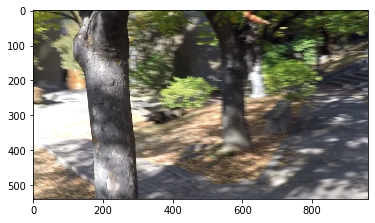

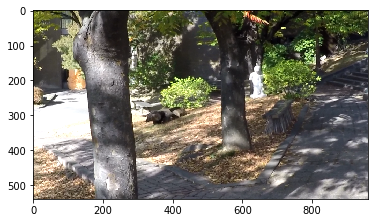

(540, 960, 3) (540, 960, 3)


In [14]:
env = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_valid', map_size=1099511627776)
env_gt = lmdb.open('/home/zhong/data/gopro_ds_lmdb/gopro_ds_valid_gt', map_size=1099511627776)
txn = env.begin()
txn_gt = env_gt.begin()
test = txn.get('010_00000039'.encode())
test = np.frombuffer(test, dtype='uint8')
test = test.reshape(540,960,3)
test_gt = txn_gt.get('010_00000039'.encode())
test_gt = np.frombuffer(test_gt, dtype='uint8')
test_gt = test_gt.reshape(540,960,3)
plt.imshow(test[:,:,[2,1,0]])
plt.figure()
plt.imshow(test_gt[:,:,[2,1,0]])
plt.show()
print(test.shape, test_gt.shape)
env.close()
env_gt.close()

torch.Size([4, 5, 3, 256, 256]) torch.Size([4, 5, 3, 256, 256])


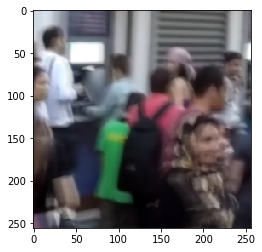

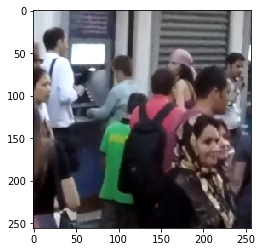

In [25]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import lmdb
import pickle
import cv2


class Crop(object):
    # Crop randomly the image in a sample.
    # Args: output_size (tuple or int): Desired output size. If int, square crop is made.
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        top, left = sample['top'], sample['left']
        new_h, new_w = self.output_size
        sample['image'] = image[top: top + new_h,
                          left: left + new_w]
        sample['label'] = label[top: top + new_h,
                          left: left + new_w]

        return sample


class Flip(object):
    # shape is (h,w,c)
    def __call__(self, sample):
        flag_lr = sample['flip_lr']
        flag_ud = sample['flip_ud']
        if flag_lr == 1:
            sample['image'] = np.fliplr(sample['image'])
            sample['label'] = np.fliplr(sample['label'])
        if flag_ud == 1:
            sample['image'] = np.flipud(sample['image'])
            sample['label'] = np.flipud(sample['label'])

        return sample


class Rotate(object):
    # shape is (h,w,c)
    def __call__(self, sample):
        flag = sample['rotate']
        if flag == 1:
            sample['image'] = sample['image'].transpose(1,0,2)
            sample['label'] = sample['label'].transpose(1,0,2)

        return sample

    
class Sharp2Sharp(object):
    def __call__(self, sample):
        flag = sample['s2s']
        if flag < 1:
            sample['image'] = sample['label'].copy()
        return sample

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = np.ascontiguousarray(image.transpose((2, 0, 1))[np.newaxis, :])
        label = np.ascontiguousarray(label.transpose((2, 0, 1))[np.newaxis, :])
        sample['image'] = torch.from_numpy(image).float()
        sample['label'] = torch.from_numpy(label).float()
        return sample


class Deblur_Dataset(Dataset):
    def __init__(self, datapath='./lmdb_dataset/', dataset_type='train', frames=5, num_ff=0, num_fb=0, verbose=False):
        if dataset_type == 'train':
            self.datapath_blur = datapath + 'gopro_ds_train'
            self.datapath_gt = datapath + 'gopro_ds_train_gt'
            self.seq_id_start = 0
            self.seq_id_end = 21
#             self.seq_id_end = 2
            f = open(datapath+'gopro_ds_info_train.pkl', 'rb')
            self.seqs_info = pickle.load(f)
            f.close()
        elif dataset_type == 'valid':
            self.datapath_blur = datapath + 'gopro_ds_valid'
            self.datapath_gt = datapath + 'gopro_ds_valid_gt'
            self.seq_id_start = 0
            self.seq_id_end = 10
#             self.seq_id_end = 1
            f = open(datapath+'gopro_ds_info_valid.pkl', 'rb')
            self.seqs_info = pickle.load(f)
            f.close()
        self.verbose = verbose
        self.seq_num = self.seq_id_end - self.seq_id_start + 1
        self.frames = frames
        self.crop_size = 256
        self.W = 960
        self.H = 540
        self.down_ratio = 1
        self.C = 3
        self.num_ff = num_ff
        self.num_fb = num_fb
        self.env_blur = lmdb.open(self.datapath_blur, map_size=1099511627776)
        self.env_gt = lmdb.open(self.datapath_gt, map_size=1099511627776)
        self.txn_blur = self.env_blur.begin()
        self.txn_gt = self.env_gt.begin()
#         self.transform = transforms.Compose([Crop(256), Flip(), Rotate(), Sharp2Sharp(), ToTensor()])
        self.transform = transforms.Compose([Crop(256), Flip(), ToTensor()])

        
    def get_index(self):
        seq_idx = random.randint(self.seq_id_start, self.seq_id_end)
        frame_idx = random.randint(0, self.seqs_info[seq_idx]['length'] - self.frames)

        return seq_idx, frame_idx

    def get_img(self, seq_idx, frame_idx, sample):
        code = '%03d_%08d' % (seq_idx, frame_idx)
        code = code.encode()
        img_blur = self.txn_blur.get(code)
        img_blur = np.frombuffer(img_blur, dtype='uint8')
        img_blur = img_blur.reshape(self.H, self.W, self.C)
        img_gt = self.txn_gt.get(code)
        img_gt = np.frombuffer(img_gt, dtype='uint8')
        img_gt = img_gt.reshape(self.H, self.W, self.C)
        sample['image'] = img_blur
        sample['label'] = img_gt
        sample = self.transform(sample)
        if self.verbose:
            print('code', code, 's2s', sample['s2s'], 'top', sample['top'], 'left', sample['left'], 'flip_lr', sample['flip_lr'], 'flip_ud', sample['flip_ud'], 'rotate',
                  sample['rotate'])

        return sample['image'], sample['label']

    def __getitem__(self, idx):
        top = random.randint(0, int(self.H*self.down_ratio) - self.crop_size)
        left = random.randint(0, int(self.W*self.down_ratio) - self.crop_size)
        flip_lr_flag = random.randint(0, 1)
        flip_ud_flag = random.randint(0, 1)
        rotate_flag = random.randint(0, 1)
        s2s_flag = random.randint(0, 9)
#         reverse_flag = random.randint(0, 1)
        sample = {'s2s': s2s_flag, 'top': top, 'left': left, 'flip_lr': flip_lr_flag, 'flip_ud': flip_ud_flag, 'rotate': rotate_flag}
        seq_idx, frame_idx = self.get_index()
        imgs_blur = []
        imgs_gt = []
        for i in range(self.frames):
            img_blur, img_gt = self.get_img(seq_idx, frame_idx + i, sample)
            imgs_blur.append(img_blur)
            imgs_gt.append(img_gt)
        # data augmentation for sequence, reverse
#         if reverse_flag == 1:
#             imgs_blur.reverse()
#             imgs_gt.reverse()
#             if self.verbose: print('reversed')
#         else:
#             if self.verbose: print('not reversed')
        return torch.cat(imgs_blur, dim=0), torch.cat(imgs_gt[self.num_fb:self.frames - self.num_ff], dim=0)

    def __len__(self):
        return self.seqs_info['length']-(self.frames-1)*self.seqs_info['num']

    
path = '/home/zhong/data/gopro_ds_lmdb/'
dataset = Deblur_Dataset(datapath=path, dataset_type='valid', frames=5)
x,y = dataset[12]
plt.imshow(x[0].permute(1,2,0).numpy()[:,:,[2,1,0]]/255)
plt.figure()
plt.imshow(y[0].permute(1,2,0).numpy()[:,:,[2,1,0]]/255)
loader = DataLoader(dataset, batch_size=4, num_workers=8, pin_memory=True, drop_last=True)
for x,y in loader:
    print(x.shape, y.shape)
    break